<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: Predict West Nile Virus Presence in Mosquitos across the City of Chicago<br>
# Part 2: Feature Engineering

This workbook is 2 out of 4 parts of a prediction model to determine the occurrence of West Nile Virus (WNV). The focus of this part is to perform feature engineering on the datasets for train and weather that will be fed to the model. In general, all the features from Train and Weather datasets do not have strong correlation to WNV presence. Thus, focusing on Feature Engineering is imperative in order to create stronger correlating features for better modelling.

### Contents:
- [Train and Test Feature Engineering](#Train-and-Test-Feature-Engineering)
    - [Addressing Multirow Leakage](#Addressing-Multirow-Leakage)
    - [Clustering of Trap Location by Geographical Proximity](#Clustering-of-Trap-Location-by-Geographical-Proximity)
- [Weather Feature Engineering](#Weather-Feature-Engineering)
    - [Pairwise Correlation of Weather Features](#Pairwise-Correlation-of-Weather-Features)
    - [Rolling Average for Weather Features](#Rolling-Average-for-Weather-Features)
- [Exporting Model Dataset](#Exportin-Model-Dataset)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# For Clustering of Trap Locations
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# Importing datasets for further feature engineering
train_df = pd.read_csv('../datasets/train_df.csv')
test_df = pd.read_csv('../datasets/test_df.csv')
weather_df = pd.read_csv('../datasets/weather_df.csv')
train_weather_df = pd.read_csv('../datasets/train_weather.csv')

In [4]:
weather_df['Date']=pd.to_datetime(weather_df['Date'])
weather_df.set_index('Date', inplace=True)
weather_df.sort_index(inplace=True)

train_weather_df['Date']=pd.to_datetime(train_weather_df['Date'])
train_weather_df.set_index('Date', inplace=True)
train_weather_df.sort_index(inplace=True)

# Train and Test Feature Engineering

## Addressing Multirow Leakage

From the data description, we know that the test results are organized in such a way that when the number of mosquitos exceed 50, they are split into another record (another row in the dataset), such that the number of mosquitos are capped at 50. This will lead to duplicated observations for a given `'Date'`, `'Address'`, and `'Species'`. Since the Test dataset does not have `'NumMosquito'` column present, we will represent the multirows by a new feature, `'Row_count'`, which adds the total number of rows for each observation.

In [5]:
train_df['count'] = 1
count = train_df.groupby(['Date', 'Address', 'Species']).sum().reset_index()
count.drop(['Latitude', 'Longitude', 'NumMosquitos',
       'WnvPresent', 'Day', 'Month', 'Year', 'Species_CULEX PIPIENS',
       'Species_CULEX RESTUANS',
           ], axis = 1, inplace=True)
count.rename(columns={'count': 'Row_count'}, inplace=True)
train_df = train_df.merge(count, how = 'left', on =['Date', 'Address', 'Species'])
train_df.drop(columns='count', inplace=True)

In [6]:
test_df['count'] = 1
count = test_df.groupby(['Date', 'Address', 'Species']).sum().reset_index()
count.drop([ 'Id', 'Latitude', 'Longitude', 'Day',
       'Month', 'Year', 'Species_CULEX PIPIENS', 'Species_CULEX RESTUANS',
           ], axis = 1, inplace=True)
count.rename(columns={'count': 'Address_count'}, inplace=True)
test_df = test_df.merge(count, how = 'left', on =['Date', 'Address', 'Species'])
test_df.drop(columns='count', inplace=True)

## Clustering of Trap Location by Geographical Proximity

### Clustering Trap Locations by Longitude/Latitude Grid

In [7]:
#using train + test datasets for location
merge_df = pd.concat([train_df,test_df], axis = 0)

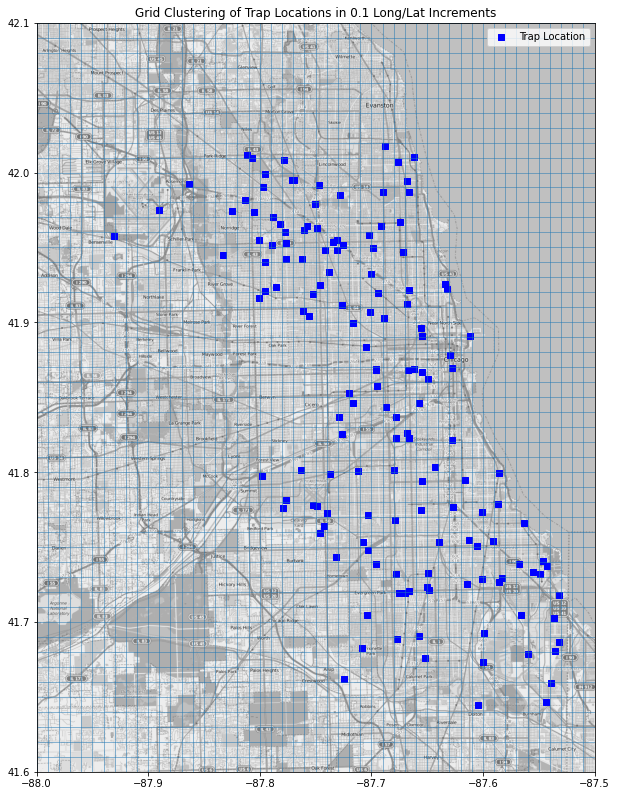

In [8]:
#Grid clustering of trap locations in 0.1 Long/Lat increments
mapdata = np.loadtxt("../datasets/mapdata_copyright_openstreetmap_contributors.txt")

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations = merge_df[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='s', color='Blue', label='Trap Location')
plt.legend()

for num in np.linspace(41.6, 42.1, 51):
    plt.axhline(num, lw = 0.5)

for num in np.linspace(-87.5, -88, 51):
    plt.axvline(num, lw = 0.5)

plt.title('Grid Clustering of Trap Locations in 0.1 Long/Lat Increments');

We can try to conglomerate points through applying a grid and classifying points within the same square as the same cluster. Note that 0.1 Long/Lat translates to 11.1km in distance and that is more than the empirical range for an adult Culex mosquito (3.2km).[*source*](https://www.cdc.gov/mosquitoes/about/life-cycles/culex.html) 

We can try to reduce the increments to match the empirical range. However, an issue with this method is that there is an increase risk that certain points which are actually closer than 3.2km will fall on either side of an edge between two squares. This would mean that geographical neighbours can be classified under two different clusters using the above method. Hence, a better clustering technique has to be employed to effectively cluster these trap locations.


### Clustering Trap Locations using Hierarchical Clustering

In [9]:
#extract the long/lat data w address

address_locations = merge_df.loc[:,['Address','Longitude', 'Latitude']]
address_locations.drop_duplicates(inplace=True)
address_locations.set_index('Address', drop=True, inplace=True)
address_locations

,Longitude,Latitude
Address,,
"4100 North Oak Park Avenue, Chicago, IL 60634, USA",-87.800991,41.954690
"6200 North Mandell Avenue, Chicago, IL 60646, USA",-87.769279,41.994991
"7900 West Foster Avenue, Chicago, IL 60656, USA",-87.824812,41.974089
"1500 West Webster Avenue, Chicago, IL 60614, USA",-87.666455,41.921600
"2500 West Grand Avenue, Chicago, IL 60654, USA",-87.654491,41.891118
...,...,...
"3700 North Kilbourn Avenue, Chicago, IL 60641, USA",-87.741340,41.948280
"4600 North Melvina Avenue, Chicago, IL 60630, USA",-87.781978,41.965571
"6500 West Dakin Street, Chicago, IL 60634, USA",-87.789234,41.951878


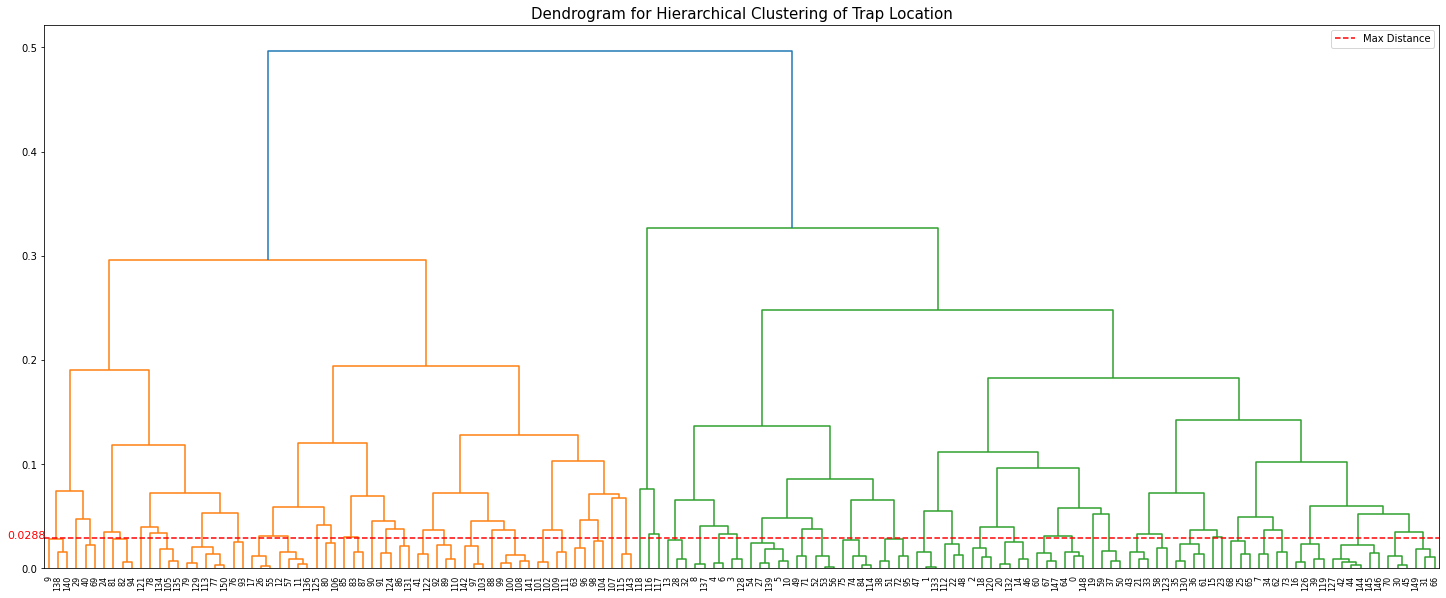

In [10]:
# Perform hierarchical clustering. 
# Z linkage matrix
Z = linkage(address_locations, method='complete', metric='euclidean')

# We will plot a dendrogram here
plt.figure(figsize=(25,10))
_ = dendrogram(Z, leaf_rotation=90., leaf_font_size=8.)

max_dist = 0.02882882882882883 # pairwise distance between two points. Represents the Long/Lat degree conversion from 3.2km (known max range of Culex mosquitoes)

#Plotting Dendrogram
plt.axhline(max_dist, color = 'red', linestyle = "--", label = 'Max Distance');
plt.legend();
plt.title('Dendrogram for Hierarchical Clustering of Trap Location', size = 15);
plt.text(x = -40,y=0.0288, s=0.0288, color = 'red', size = 11);

We set the max distance (cutoff threshold) beyond which points cannot be clustered as 0.0288 degrees, which represents the Longitude/Latitude conversion of 3.2km (previously explained as the empirical maximum flight range for Culex mosquitoes).

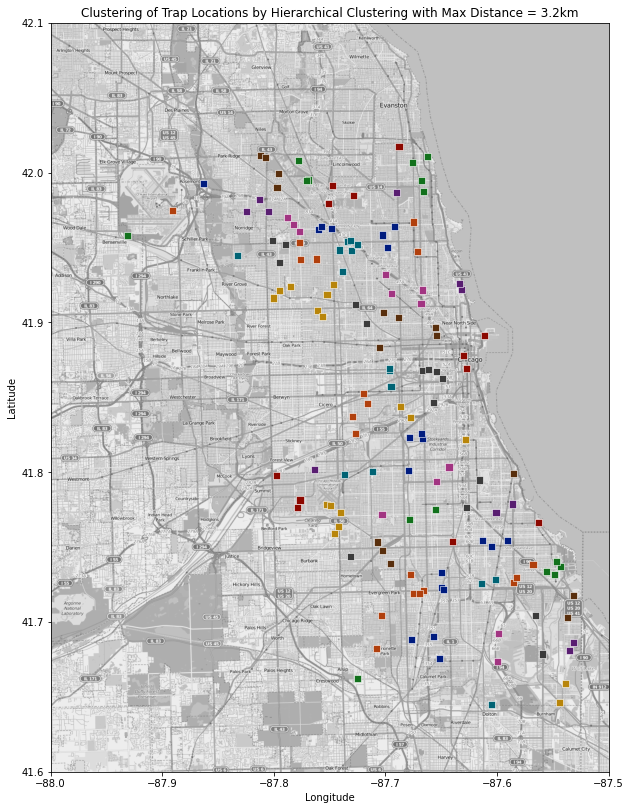

In [11]:
#adding cluster labels onto the address_locations dataframe
address_locations['cluster'] = fcluster(Z, max_dist, criterion='distance')

#Plotting clustered trap locations onto the map
mapdata = np.loadtxt("../datasets/mapdata_copyright_openstreetmap_contributors.txt")

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

sns.scatterplot(
    x = address_locations['Longitude'],
    y = address_locations['Latitude'],
    data = address_locations,
    palette = "dark",
    hue = 'cluster',
    marker='s',
    legend = False,
    s = 50,
);

plt.title('Clustering of Trap Locations by Hierarchical Clustering with Max Distance = 3.2km');

From the above plot, we see that geographical neighbours (denoted by neighbouring squares of the same colour) have been clustered together. 

### Correlation Heatmap of Clusters to WnvPresent

In [12]:
# Adding cluster information to train dataset
address_locations["Address"] = address_locations.index
train_df['cluster'] = train_df['Address'].map(lambda x: address_locations[address_locations['Address'] == str(x)]['cluster'].values[0])

In [13]:
# Adding cluster information to test dataset
address_locations["Address"] = address_locations.index
test_df['cluster'] = test_df['Address'].map(lambda x: address_locations[address_locations['Address'] == str(x)]['cluster'].values[0])

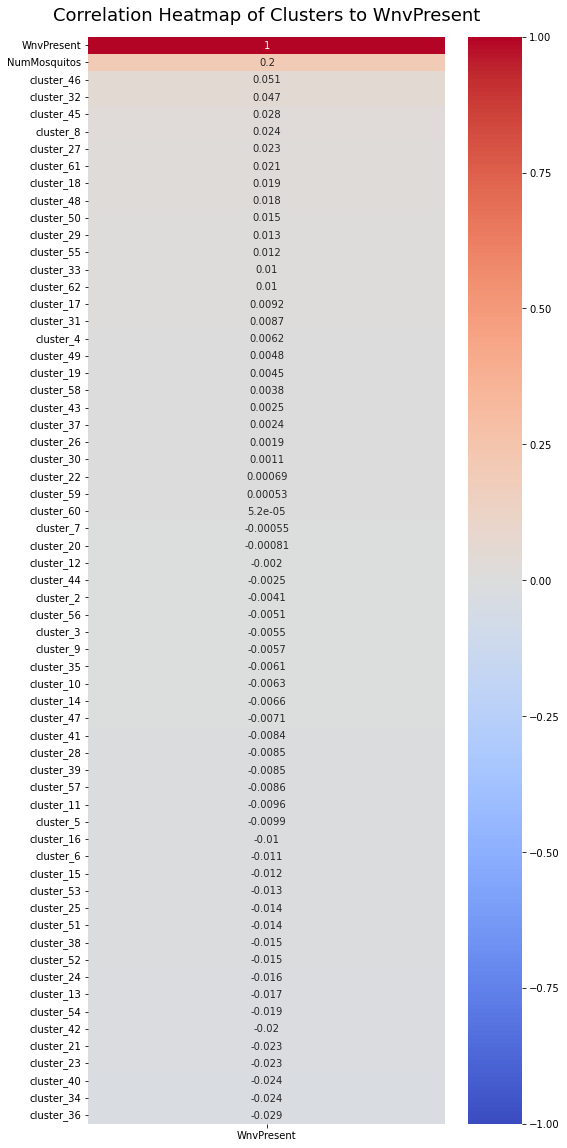

In [14]:
train_cluster = train_df.loc[:, ['cluster', 'NumMosquitos', 'WnvPresent']]
train_cluster = pd.get_dummies(train_cluster, columns=['cluster'], drop_first=True)

# Plot heatmap of Cluster correlating to WnvPresent
plt.figure(figsize=(8, 20))
heatmap = sns.heatmap(train_cluster.corr()[['WnvPresent']].sort_values(by='WnvPresent', ascending=False), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Correlation Heatmap of Clusters to WnvPresent', fontdict={'fontsize':18}, pad=16);

Overall, we see that the correlation of location has improved over the addresses. For example, `cluster_46` consisting of:

- `7200 North Oketo Avenue, Chicago, IL 60631, USA`,
- `7100 North Harlem Avenue, Chicago, IL 60631, USA`,
- `6500 North Oak Park Avenue, Chicago, IL 60631, USA`, and
- `6000 North Avondale Avenue, Chicago, IL 60631, USA` 

has an increased correlation score of 0.051. Previously, these only had a correlation score of 0.019, 0.027, 0.034, and 0.24 respectively (as seen below). Thus, we believe this will help in improving model accuracy.

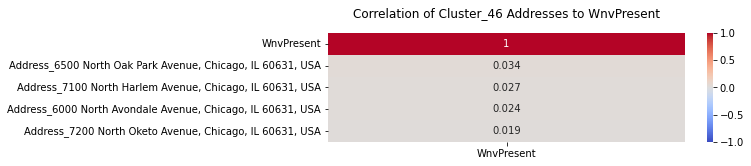

In [15]:
train_address = train_weather_df.loc[:, ['Address', 'NumMosquitos', 'WnvPresent']]
train_address = pd.get_dummies(train_address, drop_first=True)

# Plot heatmap of Address correlating to WnvPresent
plt.figure(figsize=(8, 2))
heatmap = sns.heatmap(
    train_address.loc[:,[
        'WnvPresent',
        'Address_7200 North Oketo Avenue, Chicago, IL 60631, USA',
        'Address_7100 North Harlem Avenue, Chicago, IL 60631, USA',
        'Address_6500 North Oak Park Avenue, Chicago, IL 60631, USA',
        'Address_6000 North Avondale Avenue, Chicago, IL 60631, USA'
    ]].corr()[['WnvPresent']].sort_values(by='WnvPresent', ascending=False).head(17), 
    vmin=-1,
    vmax=1,
    annot=True,
    cmap='coolwarm'
)
heatmap.set_title('Correlation of Cluster_46 Addresses to WnvPresent', fontdict={'fontsize':12}, pad=16);

In [16]:
#dummifying cluster column
train_df = pd.get_dummies(train_df, columns=['cluster'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['cluster'], drop_first=True)

# Weather Feature Engineering

## Pairwise Correlation of Weather Features


In [17]:
corr_matrix = train_weather_df.corr().abs()

sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1)
                  .astype(bool))
                  .stack()
                  .sort_values(ascending=False))

# Convert to dataframe and reset multi-level index
corr_df = pd.DataFrame(sol.head(20)).reset_index()

# Rename columns
corr_df.columns = 'v1', 'v2', 'pair_corr'

In [18]:
def corr_target(row):
    row['v1_y_corr'] = train_weather_df.corr()['WnvPresent'][row['v1']]
    row['v2_y_corr'] = train_weather_df.corr()['WnvPresent'][row['v2']]
    return row

corr_df = corr_df.apply(corr_target, axis=1)

In [19]:
corr_df.head(10)

,v1,v2,pair_corr,v1_y_corr,v2_y_corr
0,DewPoint,WetBulb,0.973423,0.085973,0.080827
1,Sunrise,Sunset,0.959904,0.105668,-0.068704
2,Tavg,WetBulb,0.952375,0.064880,0.080827
3,Tmax,Tavg,0.950623,0.049059,0.064880
4,Tavg,Cool,0.950352,0.064880,0.058690
5,Tmin,Tavg,0.938147,0.074372,0.064880
6,Tmin,WetBulb,0.937047,0.074372,0.080827
7,WetBulb,Cool,0.914281,0.080827,0.058690
8,Tmin,Cool,0.904038,0.074372,0.058690
9,ResultSpeed,AvgSpeed,0.901876,-0.046928,-0.030380


From the above pairwise correlation we see that weather features are highly correlated with each other. For our model, we will be dropping one of the feature from feature pairs with more than 95% positive pairwise correlation, choosing for those with higher correlation to target. 

Specifically, `'WetBulb'`, `'Sunset'`, `'Tmax'`, and `'Cool'` will be dropped.

In [20]:
weather_df.drop(['WetBulb', 'Sunset',
                 'Tmax','Cool',
],axis=1, inplace=True)

## Rolling Average for Weather Features

Based on external research and empirical data, sexual activity in C. pipiens begins within the first 2–3 days of emergence from the larval development stage. [source](https://en.wikipedia.org/wiki/Culex_pipiens) Prior to mating, the female mosquito locates host for blood feeding. They then become vectors for WNV when they feed on infected birds.

Once mating has occured, they will proceed to lay their eggs and this is when the female mosquitoes get trapped in the traps used in this project.

Thus, for our project, we will be focusing on the weather conditions within this 2 day period prior to the observation date because:

1) This is when female mosquitoes feed on hosts and become vectors.<br>
2) This is when sexual activity for the mosquitoes occur.<br>
3) This is when the female mosquitoes lay their eggs once mating has occured.<br>

Thus, we will be use a rolling average of 2 days for the weather condition prior to the observation date for our model.

In [21]:
weather_df_roll = weather_df.rolling(2).mean() #
weather_df_roll.fillna(method='backfill',inplace=True)

train_df['Date']=pd.to_datetime(train_df['Date'])
train_df.set_index('Date', inplace=True)
train_df.sort_index(inplace=True)

train_weather_model = pd.merge(train_df, weather_df_roll, left_on='Date',right_index=True)


In [22]:
#checking if transformation was done properly
print(weather_df_roll.loc['2007-05-29']['Tavg'])
print(train_weather_model.loc['2007-05-29']['Tavg'][0])

70.25
70.25


In [23]:
#repeating for test dataset
test_df['Date']=pd.to_datetime(test_df['Date'])
test_df.set_index('Date', inplace=True)
test_df.sort_index(inplace=True)

#merging to test data set
test_weather_model = pd.merge(test_df, weather_df_roll, left_on = 'Date' ,right_index=True)

In [24]:
#checking if transformation was done properly
print(weather_df_roll.loc['2008-06-11']['Tavg'])
print(test_weather_model.loc['2008-06-11']['Tavg'][0])

72.25
72.25


# Exporting Model Dataset

Irrelevant columns (for our model) to be dropped: `'Address'`, `'Latitude'`, `'Longitude'`, `'Species'`,`'NumMosquitos'`, `'Day'`, `'Month'`, `'Year'`, `'Trap'`.

In [25]:
train_weather_model.drop(['Address','Latitude','Longitude',
                          'Day', 'Month','Year',
                       'NumMosquitos','Trap','Species'],axis=1,inplace=True)
test_weather_model.drop(['Address','Latitude','Longitude',
                         'Day', 'Month','Year'
                       ,'Trap','Species'],axis=1,inplace=True)


In [26]:
train_weather_model.to_csv('../datasets/train_weather_model.csv', index=False)
test_weather_model.to_csv('../datasets/test_weather_model.csv', index=False)

In [27]:
address_locations.to_csv('../datasets/address_location.csv', index=True)